# Fitting a Mixture Model with Gibbs Sampling

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy import stats
from collections import namedtuple, Counter

C:\Users\risto\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\risto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\risto\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


Suppose we receive some data that looks like the following:

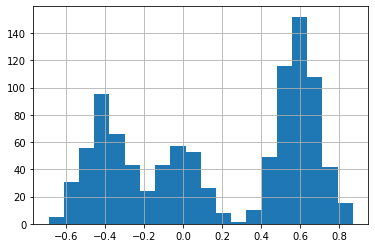

In [2]:
data = pd.read_csv("clusters.csv", header=None)[1]
_=data.hist(bins=20)

In [3]:
data.size

1000

In [4]:
data.head()

0    0.002681
1   -0.341619
2   -0.352397
3    0.682440
4    0.504524
Name: 1, dtype: float64

In [5]:
data.tail()

995   -0.235853
996    0.480309
997    0.001624
998   -0.629820
999    0.637904
Name: 1, dtype: float64

In [6]:
data.describe()

count    1000.000000
mean        0.169591
std         0.455007
min        -0.690683
25%        -0.303794
50%         0.176051
75%         0.596546
max         0.871537
Name: 1, dtype: float64

It appears that these data exist in three separate clusters. We want to develop a method for finding these _latent_ clusters. One way to start developing a method is to attempt to describe the process that may have generated these data.

For simplicity and sanity, let's assume that each data point is generated independently of the other. Moreover, we will assume that within each cluster, the data points are identically distributed. In this case, we will assume each cluster is normally distributed and that each cluster has the same variance, $\sigma^2$.

Given these assumptions, our data could have been generated by the following process. For each data point, randomly select 1 of 3 clusters from the distribution $\text{Discrete}(\pi_1, \pi_2, \pi_3)$. Each cluster $k$ corresponds to a parameter $\theta_k$ for that cluster, sample a data point from $\mathcal{N}(\theta_k, \sigma^2)$.

Equivalently, we could consider these data to be generated from a probability distribution with this probability density function:

$$
p(x_i \,|\, \pi, \theta_1, \theta_2, \theta_3, \sigma)=
    \sum_{k=1}^3 \pi_k\cdot
        \frac{1}{\sigma\sqrt{2\pi}}
        \text{exp}\left\{
            \frac{-(x_i-\theta_k)^2}{2\sigma^2}
         \right\}
$$

where $\pi$ is a 3-dimensional vector giving the _mixing proportions_. In other words, $\pi_k$ describes the proportion of points that occur in cluster $k$.


That is, _the probability distribution describing $x$ is a linear combination of normal distributions_.

We want to use this _generative_ model to formulate an algorithm for determining the particular parameters that generated the dataset above. The $\pi$ vector is unknown to us, as is each cluster mean $\theta_k$. 

We would also like to know $z_i\in\{1, 2, 3\}$, the latent cluster for each point. It turns out that introducing $z_i$ into our model will help us solve for the other values.

The joint distribution of our observed data (`data`) along with the assignment variables is given by:

\begin{align}
p(\mathbf{x}, \mathbf{z} \,|\, \pi, \theta_1, \theta_2, \theta_3, \sigma)&=
       p(\mathbf{z} \,|\, \pi)
       p(\mathbf{x} \,|\, \mathbf{z}, \theta_1, \theta_2, \theta_3, \sigma)\\
       &= \prod_{i=1}^N p(z_i \,|\, \pi)
           \prod_{i=1}^N p(x_i \,|\, z_i, \theta_1, \theta_2, \theta_3, \sigma) \\
       &= \prod_{i=1}^N \pi_{z_i}
           \prod_{i=1}^N 
           \frac{1}{\sigma\sqrt{2\pi}}
        \text{exp}\left\{
            \frac{-(x_i-\theta_{z_i})^2}{2\sigma^2}
         \right\}\\
       &= \prod_{i=1}^N 
           \left(
           \pi_{z_i}
           \frac{1}{\sigma\sqrt{2\pi}}
        \text{exp}\left\{
            \frac{-(x_i-\theta_{z_i})^2}{2\sigma^2}
         \right\}
         \right)\\
       &=
           \prod_i^n
           \prod_k^K
           \left(
               \pi_k 
               \frac{1}{\sigma\sqrt{2\pi}}
        \text{exp}\left\{
            \frac{-(x_i-\theta_k)^2}{2\sigma^2}
         \right\}
           \right)^{\delta(z_i, k)}
\end{align}

### Keeping Everything Straight

Before moving on, we need to devise a way to keep all our data and parameters straight. Following ideas suggested by [Keith Bonawitz](http://people.csail.mit.edu/bonawitz/Composable%20Probabilistic%20Inference%20with%20Blaise%20-%20Keith%20Bonawitz%20PhD%20Thesis.pdf), let's define a "state" object to store all of this data. 

It won't yet be clear why we are defining some components of `state`, however we will use each part eventually! As an attempt at clarity, I am using a trailing underscore in the names of members that are fixed. We will update the other parameters as we try to fit the model.

In [19]:
SuffStat = namedtuple('SuffStat', 'theta N')

def update_suffstats(state):
    for cluster_id, N in Counter(state['assignment']).items():
        points_in_cluster = [x 
            for x, cid in zip(state['data_'], state['assignment'])
            if cid == cluster_id
        ]
        mean = np.array(points_in_cluster).mean()
        
        state['suffstats'][cluster_id] = SuffStat(mean, N)
    print(state['suffstats'])

def initial_state():
    num_clusters = 3
    alpha = 1.0
    cluster_ids = range(num_clusters)

    state = {
        'cluster_ids_': cluster_ids,
        'data_': data,
        'num_clusters_': num_clusters,
        'cluster_variance_': .01,
        'alpha_': alpha,
        'hyperparameters_': {
            "mean": 0,
            "variance": 1,
        },
        'suffstats': [None, None, None],
        'assignment': [random.choice(cluster_ids) for _ in data],
        'pi': [alpha / num_clusters for _ in cluster_ids],
        'cluster_means': [-1, 0, 1]
    }
    update_suffstats(state)
    return state

state = initial_state()

[SuffStat(theta=0.19835086696028006, N=340), SuffStat(theta=0.1486609379002236, N=333), SuffStat(theta=0.1610023824133533, N=327)]


In [20]:
for k, v in sorted(state.items()):
    print(k)

alpha_
assignment
cluster_ids_
cluster_means
cluster_variance_
data_
hyperparameters_
num_clusters_
pi
suffstats


### Gibbs Sampling

The [theory of Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) tells us that given some data $\bf y$ and a probability distribution $p$ parameterized by $\gamma_1, \ldots, \gamma_d$, we can successively draw samples from the distribution by sampling from

$$\gamma_j^{(t)}\sim p(\gamma_j \,|\, \gamma_{\neg j}^{(t-1)})$$
    
where $\gamma_{\neg j}^{(t-1)}$ is all current values of $\gamma_i$ except for $\gamma_j$. If we sample long enough, these $\gamma_j$ values will be random samples from $p$. 

In deriving a Gibbs sampler, it is often helpful to observe that 

$$
    p(\gamma_j \,|\, \gamma_{\neg j})
        = \frac{
            p(\gamma_1,\ldots,\gamma_d)
        }{
            p(\gamma_{\neg j})
        } \propto p(\gamma_1,\ldots,\gamma_d).
$$

The conditional distribution is proportional to the joint distribution. We will get a lot of mileage from this simple observation by dropping constant terms from the joint distribution (relative to the parameters we are conditioned on).

The $\gamma$ values in our model are each of the $\theta_k$ values, the $z_i$ values, and the $\pi_k$ values. Thus, we need to derive the conditional distributions for each of these.

Many derivation of Gibbs samplers that I have seen rely on a lot of handwaving and casual appeals to conjugacy. I have tried to add more mathematical details here. I would gladly accept feedback on how to more clearly present the derivations! I have also tried to make the derivations more concrete by immediately providing code to do the computations in this specific case. 

#### Conditional Distribution of Assignment

For berevity, we will use

$$
p(z_i=k \,|\, \cdot)=
p(z_i=k \,|\, 
        z_{\neg i}, \pi,
        \theta_1, \theta_2, \theta_3, \sigma, \bf x
        ).
        $$
        
Because cluster assignements are conditionally independent given the cluster weights and paramters,

\begin{align}
    p(z_i=k \,|\, \cdot) 
        &\propto
           \prod_i^n
           \prod_k^K
           \left(
               \pi_k 
               \frac{1}{\sigma\sqrt{2\pi}}
        \text{exp}\left\{
            \frac{-(x_i-\theta_k)^2}{2\sigma^2}
         \right\}
           \right)^{\delta(z_i, k)} \\
        &\propto
            \pi_k \cdot
            \frac{1}{\sigma\sqrt{2\pi}} 
            \text{exp}\left\{
                \frac{-(x_i-\theta_k)^2}{2\sigma^2}
             \right\}
\end{align}

This equation intuitively makes sense: point $i$ is more likely to be in cluster $k$ if $k$ is itself probable ($\pi_k\gg 0$) and $x_i$ is close to the mean of the cluster $\theta_k$.

For each data point $i$, we can compute $p(z_i=k \,|\, \cdot)$ for each of cluster $k$. These values are the unnormalized parameters to a discrete distribution from which we can sample assignments.

Below, we define functions for doing this sampling. `sample_assignment` will generate a sample from the posterior assignment distribution for the specified data point. `update_assignment` will sample from the posterior assignment for each data point and update the `state` object.

In [21]:
def log_assignment_score(data_id, cluster_id, state):
    """log p(z_i=k \,|\, \cdot) 
    
    We compute these scores in log space for numerical stability.
    """
    x = state['data_'][data_id]
    theta = state['cluster_means'][cluster_id]
    var = state['cluster_variance_']
    log_pi = np.log(state['pi'][cluster_id])
    return log_pi + stats.norm.logpdf(x, theta, var)


def assigment_probs(data_id, state):
    """p(z_i=cid \,|\, \cdot) for cid in cluster_ids
    """
    scores = [log_assignment_score(data_id, cid, state) for cid in state['cluster_ids_']]

    scores = np.exp(np.array(scores))
    return scores / scores.sum()


def sample_assignment(data_id, state):
    """Sample cluster assignment for data_id given current state
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006 http://cs.brown.edu/~sudderth/papers/sudderthPhD.pdf
    """
    try:
        p = assigment_probs(data_id, state)
        return np.random.choice(state['cluster_ids_'], p=p)
    except:
        #hack, sometimes all p-s are zero, then return cluster 0
        return 0


def update_assignment(state):
    """Update cluster assignment for each data point given current state 
    
    cf Step 1 of Algorithm 2.1 in Sudderth 2006
    """
    for data_id, x in enumerate(state['data_']):
        state['assignment'][data_id] = sample_assignment(data_id, state)
    update_suffstats(state)

#### Conditional Distribution of Mixture Weights

We can similarly derive the conditional distributions of mixture weights by an application of Bayes theorem. Instead of updating each component of $\pi$ separately, we update them together (this is called blocked Gibbs).

\begin{align}
p(\pi \,|\, \cdot)&=
p(\pi \,|\, 
        \bf{z}, 
        \theta_1, \theta_2, \theta_3,
        \sigma, \mathbf{x}, \alpha
        )\\
&\propto
p(\pi \,|\, 
        \mathbf{x}, 
        \theta_1, \theta_2, \theta_3,
        \sigma, \alpha
        )
p(\bf{z}\ \,|\, 
        \mathbf{x}, 
        \theta_1, \theta_2, \theta_3,
        \sigma, \pi, \alpha
        )\\
&=
p(\pi \,|\, 
        \alpha
        )
p(\bf{z}\ \,|\, 
        \mathbf{x}, 
        \theta_1, \theta_2, \theta_3,
        \sigma, \pi, \alpha
        )\\
&=
\prod_{i=1}^K \pi_k^{\alpha/K - 1}
\prod_{i=1}^K \pi_k^{\sum_{i=1}^N \delta(z_i, k)} \\
&=\prod_{k=1}^3 \pi_k^{\alpha/K+\sum_{i=1}^N \delta(z_i, k)-1}\\
&\propto \text{Dir}\left(
    \sum_{i=1}^N \delta(z_i, 1)+\alpha/K, 
    \sum_{i=1}^N \delta(z_i, 2)+\alpha/K,
    \sum_{i=1}^N \delta(z_i, 3)+\alpha/K
    \right)
\end{align}

Here are Python functions to sample from the mixture weights given the current `state` and to update the mixture weights in the `state` object.

In [22]:
def sample_mixture_weights(state):
    """Sample new mixture weights from current state according to 
    a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    ss = state['suffstats']
    alpha = [ss[cid].N + state['alpha_'] / state['num_clusters_'] 
             for cid in state['cluster_ids_']]
    return stats.dirichlet(alpha).rvs(size=1).flatten()

def update_mixture_weights(state):
    """Update state with new mixture weights from current state
    sampled according to a Dirichlet distribution 
    
    cf Step 2 of Algorithm 2.1 in Sudderth 2006
    """
    state['pi'] = sample_mixture_weights(state)

#### Conditional Distribution of Cluster Means

Finally, we need to compute the conditional distribution for the cluster means.

We assume the unknown cluster means are distributed according to a normal distribution with hyperparameter mean $\lambda_1$ and variance $\lambda_2^2$. The final step in this derivation comes from the normal-normal conjugacy. For more information see [section 2.3 of this](http://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf) and [section 6.2 this](https://web.archive.org/web/20160304125731/http://fisher.osu.edu/~schroeder.9/AMIS900/ech6.pdf).)

\begin{align}
p(\theta_k \,|\, \cdot)&=
p(\theta_k \,|\, 
        \bf{z}, \pi,
        \theta_{\neg k},
        \sigma, \bf x, \lambda_1, \lambda_2
        ) \\
&\propto p(\left\{x_i \,|\, z_i=k\right\} \,|\, \bf{z}, \pi,
        \theta_1, \theta_2, \theta_3,
        \sigma, \lambda_1, \lambda_2) \cdot\\
    &\phantom{==}p(\theta_k \,|\, \bf{z}, \pi,
        \theta_{\neg k},
        \sigma, \lambda_1, \lambda_2)\\
&\propto p(\left\{x_i \,|\, z_i=k\right\} \,|\, \mathbf{z},
        \theta_k, \sigma)
        p(\theta_k \,|\,  \lambda_1, \lambda_2)\\
&= \mathcal{N}(\theta_k \,|\, \mu_n, \sigma_n)\\
\end{align}


$$ \sigma_n^2 = \frac{1}{
    \frac{1}{\lambda_2^2} + \frac{N_k}{\sigma^2}
    } $$
    
and 

$$\mu_n = \sigma_n^2 
    \left(
        \frac{\lambda_1}{\lambda_2^2} + 
        \frac{n\bar{x_k}}{\sigma^2}
    \right)
$$

Here is the code for sampling those means and for updating our state accordingly.

In [23]:
def sample_cluster_mean(cluster_id, state):
    cluster_var = state['cluster_variance_']
    hp_mean = state['hyperparameters_']['mean']
    hp_var = state['hyperparameters_']['variance']
    ss = state['suffstats'][cluster_id]
    
    numerator = hp_mean / hp_var + ss.theta * ss.N / cluster_var
    denominator = (1.0 / hp_var + ss.N / cluster_var)
    posterior_mu = numerator / denominator
    posterior_var = 1.0 / denominator
    
    return stats.norm(posterior_mu, np.sqrt(posterior_var)).rvs()


def update_cluster_means(state):
    state['cluster_means'] = [sample_cluster_mean(cid, state)
                              for cid in state['cluster_ids_']]

Doing each of these three updates in sequence makes a complete _Gibbs step_ for our mixture model. Here is a function to do that:

In [24]:
def gibbs_step(state):
    update_assignment(state)
    update_mixture_weights(state)
    update_cluster_means(state)

Initially, we assigned each data point to a random cluster. We can see this by plotting a histogram of each cluster.

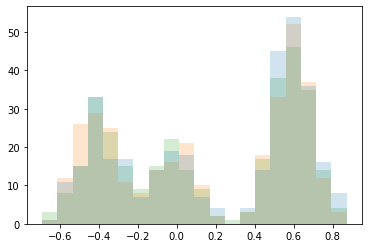

In [25]:
def plot_clusters(state):
    gby = pd.DataFrame({
            'data': state['data_'], 
            'assignment': state['assignment']}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.2 )
    
plot_clusters(state)

Each time we run `gibbs_step`, our `state` is updated with newly sampled assignments. Look what happens to our histogram after 5 steps:

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


[SuffStat(theta=0.13496924020982037, N=451), SuffStat(theta=-0.11205904387134759, N=336), SuffStat(theta=0.6871919133454462, N=213)]
[SuffStat(theta=-0.13889460949820612, N=164), SuffStat(theta=-0.2703935581228263, N=357), SuffStat(theta=0.6031323222212756, N=479)]
[SuffStat(theta=-0.007985631832239173, N=204), SuffStat(theta=-0.40602845276161054, N=303), SuffStat(theta=0.5968496069309959, N=493)]
[SuffStat(theta=-0.004622590717604885, N=203), SuffStat(theta=-0.4069648163318125, N=304), SuffStat(theta=0.5968496069309959, N=493)]
[SuffStat(theta=-0.004622590717604885, N=203), SuffStat(theta=-0.4069648163318125, N=304), SuffStat(theta=0.5968496069309959, N=493)]


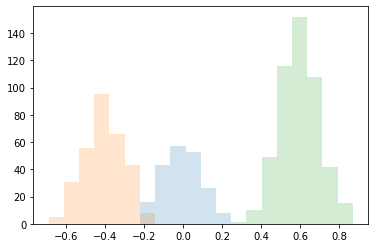

In [26]:
for _ in range(5):
    gibbs_step(state)
plot_clusters(state)

Suddenly, we are seeing clusters that appear very similar to what we would intuitively expect: three Gaussian clusters.

Another way to see the progress made by the Gibbs sampler is to plot the change in the model's log-likelihood after each step. The log likehlihood is given by:

$$
\log p(\mathbf{x} \,|\, \pi, \theta_1, \theta_2, \theta_3)
\propto \sum_x \log \left(
    \sum_{k=1}^3 \pi_k \exp 
    \left\{ 
        -(x-\theta_k)^2 / (2\sigma^2)
    \right\}
\right)
$$

We can define this as a function of our `state` object:

In [15]:
def log_likelihood(state):
    """Data log-likeliehood
    
    Equation 2.153 in Sudderth
    """
    
    ll = 0 
    for x in state['data_']:
        pi = state['pi']
        mean = state['cluster_means']
        sd = np.sqrt(state['cluster_variance_'])
        ll += np.log(np.dot(pi, stats.norm(mean, sd).pdf(x)))
    return ll

C:\Users\risto\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


<AxesSubplot:>

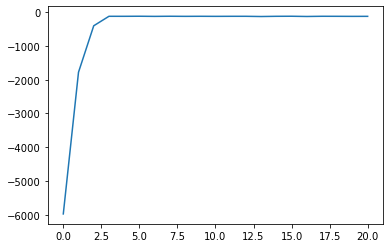

In [16]:
state = initial_state()
ll = [log_likelihood(state)]
for _ in range(20):
    gibbs_step(state)
    ll.append(log_likelihood(state))
pd.Series(ll).plot()

See that the log likelihood improves with iterations of the Gibbs sampler. This is what we should expect: the Gibbs sampler finds state configurations that make the data we have seem "likely". However, the likelihood isn't strictly monotonic: it jitters up and down. Though it behaves similarly, the Gibbs sampler isn't optimizing the likelihood function. In its steady state, it is sampling from the posterior distribution. The `state` after each step of the Gibbs sampler is a sample from the posterior.

<AxesSubplot:>

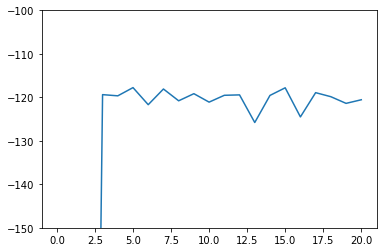

In [17]:
pd.Series(ll).plot(ylim=[-150, -100])

[In another post](/collapsed-gibbs/), I show how we can "collapse" the Gibbs sampler and sampling the assignment parameter without sampling the $\pi$ and $\theta$ values. This collapsed sampler can also be extended to the model with a Dirichet process prior that allows the number of clusters to be a parameter fit by the model.

## Notation Helper

* $N_k$, `state['suffstat'][k].N`: Number of points in cluster $k$.

* $\theta_k$, `state['suffstat'][k].theta`: Mean of cluster $k$.
* $\lambda_1$, `state['hyperparameters_']['mean']`: Mean of prior distribution over cluster means.
* $\lambda_2^2$, `state['hyperparameters_']['variance']` Variance of prior distribution over cluster means.
* $\sigma^2$, `state[cluster_variance_]`: Known, fixed variance of clusters. 

The superscript $(t)$ on $\theta_k$, $pi_k$, and $z_i$ indicates the value of that variable at step $t$ of the Gibbs sampler.

In [18]:
state['pi']

array([0.18495387, 0.33342989, 0.48161624])